# Protein Linker and Domain Analysis

This notebook provides comprehensive analysis of protein linker regions and domains from InterPro database.

## Overview

**What are protein linkers?**  
Linkers are unstructured regions between protein domains. They can be:
- **N-terminus**: Region before the first domain
- **C-terminus**: Region after the last domain  
- **Inner linkers**: Regions between domains

**What this notebook does:**
1. Fetches domain annotations from InterPro
2. Calculates linker regions between domains
3. Analyzes amino acid composition and length distributions
4. Creates visualizations
5. Clusters linkers by length for comparative analysis

## Workflow

1. **Data Collection**: Query InterPro API for domain annotations and merge overlaps
2. **Linker Calculation**: Compute regions not covered by domains
3. **Filtering**: Remove proteins with no domains
4. **Statistical Analysis**: Calculate composition and length statistics
5. **Visualization**: Generate plots and comparisons
6. **Clustering**: Group linkers by length characteristics

---

In [3]:
"""
1. Core Functions: Domain Retrieval from InterPro

These functions query the InterPro API to retrieve protein domain annotations.

**Key functions:**
- `_get_protein_seq()`: Fetches protein sequence from UniProt
- `_extract_domains_from_source()`: Queries specific InterPro databases (Pfam, SMART, etc.)
- `_get_interpro_domains()`: Aggregates domains from all databases
- `summarize_protein_domains_dict()`: Returns complete domain information for a protein
- `filter_proteins_without_domains()`: Removes proteins with no domain annotations

**Features:**
- Pagination support for large result sets
- Representative-only filtering to reduce redundancy
- Multi-database querying (Pfam, SMART, CDD, etc.)
- Quality control filtering for meaningful analysis
"""
import requests, math, os
from collections import defaultdict
import pandas as pd

INTERPRO_URL = "https://www.ebi.ac.uk/interpro/api"
CATH_URL = f"https://www.cathdb.info/version/v4_3_0/api/rest/uniprot_to_funfam"


KNOWN_DATABASES = ["InterPro", "cathgene3d", "cdd", "HAMAP", "panther", "Pfam", "PIRSF", "PRINTS", "ssf", "antifam",
                        "PROSITE" "Patterns", "PROSITE", "profile", "smart", "SFLD", "SUPERFAMILY", "ncbifam"]
# ================================
# FINAL CONSOLIDATED FUNCTIONS
# ================================

def _get_protein_seq(uniprot_acc):
    """
    Fetch protein sequence from UniProt API.
    Returns tuple (sequence, length) or (None, -1) if not found.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_acc}.json"
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        data = response.json()
        seq = data.get("sequence", {}).get("value")
        if seq:
            return seq, len(seq)
    except Exception as e:
        print(f"Error fetching data for {uniprot_acc}: {e}")
    return None, -1

# Helper function to extract domains from a specific source
def _extract_domains_from_source(uniprot_acc, source, representative_only=False):
    """
    Extract domains from a specific InterPro database source with pagination support.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession
    source : str
        Database source ('pfam', 'smart', etc.)
    representative_only : bool
        If True, only return representative domain hits
    """
    url = f"{INTERPRO_URL}/entry/{source}/protein/UniProt/{uniprot_acc}?page_size=200"
    domains = []

    while url:
        try:
            response = requests.get(url, timeout=30)
            if response.status_code == 404:
                break
            response.raise_for_status()
            data = response.json()

            results = data.get("results", []) if isinstance(data, dict) else data

            for entry in results:
                # Get entry metadata
                meta = entry.get("metadata", {})
                entry_acc = meta.get("accession")
                entry_name = meta.get("name", "")
                entry_type = meta.get("type")
                source_db = meta.get("source_database")

                # Find target protein and extract coordinates
                for protein in entry.get("proteins", []):
                    protein_acc = protein.get("accession")
                    if protein_acc and protein_acc.upper() == uniprot_acc.upper():
                        # Check for matches (entry_protein_locations)
                        for location in protein.get("entry_protein_locations", []):
                            # KEY: representative flag is at the LOCATION level, not fragment level
                            is_representative = bool(location.get("representative"))

                            # KEY FILTER: Skip non-representative locations if filtering
                            if representative_only and not is_representative:
                                continue

                            for fragment in location.get("fragments", []):
                                # Skip domains with null/None/empty names
                                if entry_name and entry_name != '':
                                    domains.append({
                                        "accession": entry_acc,
                                        "name": entry_name,
                                        "type": entry_type,
                                        "source": source_db,
                                        "start": fragment.get("start"),
                                        "end": fragment.get("end"),
                                        "score": location.get("score"),
                                        "representative": is_representative
                                    })

            # Follow pagination
            url = data.get("next") if isinstance(data, dict) else None

        except requests.exceptions.RequestException:
            break

    return domains

def _get_interpro_domains(uniprot_acc, source=None, representative_only=False):
    """
    Get protein domain coordinates from InterPro API.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession (e.g., 'P28482')
    source : str, list, or None
        - str: Query a specific database ('pfam', 'smart', 'prosite', etc.)
        - list: Query multiple specific databases (['pfam', 'smart'])
        - None: Query all available databases (default: representative hits only)
    representative_only : bool or None
        - True: Only return representative domain hits (reduces redundancy)
        - False: Return all hits
        - None: Auto-decide (True if source=None, False if source is specified)

    Returns:
    --------
    list of dict
        Each domain contains: accession, name, type, source, start, end, score, representative
        Sorted by start coordinate, then end coordinate
    """

    if source:
        # Handle list of databases
        if isinstance(source, list):
            all_domains = []
            available_dbs = []

            print(f"Querying specified databases for {uniprot_acc}: {', '.join(source)}")
            if representative_only:
                print("(filtering for representative hits only)")

            for db in source:
                domains = _extract_domains_from_source(uniprot_acc, db, representative_only)
                if domains:
                    available_dbs.append(f"{db}({len(domains)})")
                    all_domains.extend(domains)

            if available_dbs:
                print(f"Found data in: {', '.join(available_dbs)}")
            else:
                print(f"No data found in specified databases")

            # Sort by start, then end coordinate
            return sorted(all_domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                       x["end"] if x["end"] is not None else float('inf')))

        # Handle single database (string)
        else:
            domains = _extract_domains_from_source(uniprot_acc, source, representative_only)
            # Sort by start, then end coordinate
            return sorted(domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                   x["end"] if x["end"] is not None else float('inf')))

    else:
        # Query all known databases (default: representative only)
        all_domains = []
        available_dbs = []

        print(f"Scanning all databases for {uniprot_acc}...")
        if representative_only:
            print("(filtering for representative hits only)")

        for db in KNOWN_DATABASES:
            domains = _extract_domains_from_source(uniprot_acc, db, representative_only)
            if domains:
                available_dbs.append(f"{db}({len(domains)})")
                all_domains.extend(domains)

        print(f"Found data in: {', '.join(available_dbs)}")
        # Sort by start, then end coordinate
        return sorted(all_domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                   x["end"] if x["end"] is not None else float('inf')))


def filter_proteins_without_domains(proteins_dict, domains_list=None, save_path=None):
    """
    Filter out proteins that have no domain annotations.

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domain/linker info as values
        Format: {acc: {'domains': [...], 'linkers': [...]}}
    domains_list : list, optional
        Analysis-ready list of domain data to filter in parallel
    save_path : str, optional
        Path to save filtered proteins_dict as JSON

    Returns:
    --------
    tuple of (filtered_proteins_dict, filtered_domains_list, stats)
        - filtered_proteins_dict: Dict with only proteins having domains
        - filtered_domains_list: Filtered domains list (None if not provided)
        - stats: Dict with 'total_before', 'no_domains', 'total_after', 'removed'
    """
    # Count before filtering
    total_before = len(proteins_dict)
    no_domains_count = sum(1 for data in proteins_dict.values() if len(data['domains']) == 0)

    # Filter proteins_dict - keep only proteins with at least one domain
    filtered_proteins = {
        accession: data
        for accession, data in proteins_dict.items()
        if len(data['domains']) > 0
    }

    # Filter domains list if provided
    filtered_domains = None
    if domains_list is not None:
        filtered_domains = [
            protein_data
            for protein_data in domains_list
            if len(protein_data['domains']) > 0
        ]

    # Calculate statistics
    stats = {
        'total_before': total_before,
        'no_domains': no_domains_count,
        'total_after': len(filtered_proteins),
        'removed': total_before - len(filtered_proteins)
    }

    # Save if path provided
    if save_path:
        import json
        with open(os.path.expanduser(save_path), 'w') as f:
            json.dump(filtered_proteins, f, indent=2)

    return filtered_proteins, filtered_domains, stats

def summarize_protein_domains_dict(uniprot_acc, source=None, representative_only=True, skip_if_no_domains=False):
    """
    Return a dict with protein name, domains (with coords and scores), and protein length.

    Parameters:
    -----------
    uniprot_acc : str
        UniProt accession
    source : str, list, or None
        - str: Query a specific database
        - list: Query multiple specific databases
        - None: Query all available databases
    representative_only : bool or None
        - True: Only return representative domain hits
        - False: Return all hits
    skip_if_no_domains : bool
        - True: Return None if protein has no domains (default: False)
        - False: Return result even if no domains found

    Returns:
    --------
    dict with keys: uniprot_acc, protein_length, domains (sorted by start coordinate), available_databases
    Or None if skip_if_no_domains=True and no domains found
    """
    # Get protein length
    seq, length = _get_protein_seq(uniprot_acc)
    if length <= 0:
        return None

    # Get domains (this will scan databases if source=None)
    # Domains are already sorted by get_interpro_domains
    domains = _get_interpro_domains(uniprot_acc, source=source, representative_only=representative_only)

    # Skip if no domains found and filtering is enabled
    if skip_if_no_domains and len(domains) == 0:
        return None

    # Build available databases dict from domains already retrieved
    if source:
        if isinstance(source, list):
            databases = {}
            for domain in domains:
                db = domain.get('source')
                if db:
                    databases[db] = databases.get(db, 0) + 1
        else:
            databases = {source: len(domains)}
    else:
        # Extract database info from the domains we already have
        databases = {}
        for domain in domains:
            db = domain.get('source')
            if db:
                databases[db] = databases.get(db, 0) + 1

    # Build output dict
    result = {
        "uniprot_acc": uniprot_acc,
        "protein_length": length,
        "domains": domains,
        "available_databases": databases,
        "sequence": seq
    }
    return result


In [4]:
"""
2. Linker Calculation Functions

These functions compute linker regions by finding gaps between protein domains.

**Key functions:**
- `_merge_overlapping_domains()`: Merges overlapping/nested domains to avoid spurious linkers
- `compute_linker_regions()`: Calculates regions not covered by any domain
- `add_linkers_to_result()`: Adds linker information to domain data
- `get_linker_aa_count()`: Counts amino acids in a linker region

**Critical feature:**
Domain overlap handling ensures linkers are only calculated in true gaps between domains, not within overlapping domain annotations.
"""
def _merge_overlapping_domains(domains):
    """
    Merge overlapping or nested domains into non-overlapping regions.

    This ensures linkers are calculated only in regions NOT covered by any domain.

    Parameters:
    -----------
    domains : list of dict
        List of domain dictionaries with 'start' and 'end' keys

    Returns:
    --------
    list of dict
        Merged non-overlapping domain regions, sorted by start coordinate

    Example:
    --------
    Input:  [{'start': 3, 'end': 330}, {'start': 60, 'end': 70}, {'start': 120, 'end': 150}]
    Output: [{'start': 3, 'end': 330}]  # nested domains merged into parent

    Input:  [{'start': 10, 'end': 50}, {'start': 45, 'end': 80}, {'start': 100, 'end': 120}]
    Output: [{'start': 10, 'end': 80}, {'start': 100, 'end': 120}]  # overlapping merged
    """
    if not domains:
        return []

    # Sort domains by start position, then by end position (descending for tie-breaking)
    sorted_domains = sorted(domains, key=lambda x: (x["start"] if x["start"] is not None else float('inf'),
                                                     -(x["end"] if x["end"] is not None else 0)))

    merged = []
    current_start = sorted_domains[0]["start"]
    current_end = sorted_domains[0]["end"]

    for domain in sorted_domains[1:]:
        # Check if this domain overlaps or is nested within the current merged region
        if domain["start"] <= current_end + 1:  # Overlapping or adjacent (allow 1 gap to merge adjacent)
            # Extend the current merged region to include this domain
            current_end = max(current_end, domain["end"])
        else:
            # No overlap, save current merged region and start a new one
            merged.append({"start": current_start, "end": current_end})
            current_start = domain["start"]
            current_end = domain["end"]

    # Add the last merged region
    merged.append({"start": current_start, "end": current_end})

    return merged


def compute_linker_regions(domains, protein_length=None):
    """
    Compute linker regions between domains, after merging overlapping/nested domains.

    CRITICAL: Overlapping and nested domains are merged first to ensure linkers
    are only in regions NOT covered by any domain.

    Parameters:
    -----------
    domains : list of dict
        List of domain dictionaries with 'start' and 'end' keys
        (e.g., result['domains'] from summarize_protein_domains_dict)
    protein_length : int, optional
        Total protein length. If provided, includes N-terminal and C-terminal regions.

    Returns:
    --------
    list of dict
        Each linker region contains: start, end
        Sorted by start coordinate

    Example:
    --------
    Domains: [{'start': 3, 'end': 330}, {'start': 60, 'end': 70}]
    After merge: [{'start': 3, 'end': 330}]  # domain 60-70 is nested, merged
    Linkers: [{'start': 1, 'end': 2}, {'start': 331, 'end': protein_length}]
    """
    if not domains:
        if protein_length:
            return [{"start": 1, "end": protein_length}]
        return []

    # CRITICAL FIX: Merge overlapping/nested domains first
    merged_domains = _merge_overlapping_domains(domains)

    linkers = []

    # Check for N-terminal linker (before first merged domain)
    first_domain = merged_domains[0]
    if first_domain["start"] > 1:
        linker_start = 1
        linker_end = first_domain["start"] - 1
        # Only add if start <= end (length >= 1)
        if linker_start <= linker_end:
            linkers.append({
                "start": linker_start,
                "end": linker_end
            })

    # Find gaps between consecutive merged domains
    for i in range(len(merged_domains) - 1):
        current_domain = merged_domains[i]
        next_domain = merged_domains[i + 1]

        # Check if there's a gap between current domain end and next domain start
        gap_start = current_domain["end"] + 1
        gap_end = next_domain["start"] - 1

        # Only add if start <= end (length >= 1)
        if gap_start <= gap_end:
            linkers.append({
                "start": gap_start,
                "end": gap_end
            })

    # Check for C-terminal linker (after last merged domain)
    if protein_length:
        last_domain = merged_domains[-1]
        if last_domain["end"] < protein_length:
            linker_start = last_domain["end"] + 1
            linker_end = protein_length
            # Only add if start <= end (length >= 1)
            if linker_start <= linker_end:
                linkers.append({
                    "start": linker_start,
                    "end": linker_end
                })

    return linkers

def add_linkers_to_result(result):
    """
    Add linker regions to a result dict from summarize_protein_domains_dict.

    Parameters:
    -----------
    result : dict
        Result dictionary from summarize_protein_domains_dict with keys:
        'domains', 'protein_length', etc.

    Returns:
    --------
    dict
        Same result dict with added 'linkers' key containing linker regions
    """
    linkers = compute_linker_regions(result['domains'], result.get('protein_length'))
    result['linkers'] = linkers
    return result


def get_linker_aa_count(linker, seq):
    """
    Count amino acids in a linker region.

    Parameters:
    -----------
    linker : dict
        Linker dictionary with 'start' and 'end' keys (1-indexed)
    seq : str
        Full protein sequence

    Returns:
    --------
    dict
        Dictionary with amino acid single-letter codes as keys and counts as values
    """
    from collections import Counter

    # Extract linker sequence (convert to 0-indexed)
    start = linker['start'] - 1
    end = linker['end']
    linker_seq = seq[start:end]

    # Count amino acids
    aa_count = Counter(linker_seq)

    return dict(aa_count)


def get_multiple_linkers_amino_acid_count(linker_seq_pairs):
    """
    Count amino acids across multiple linker regions.

    Parameters:
    -----------
    linker_seq_pairs : list of tuples
        List of (linker, seq) pairs where:
        - linker is a dict with 'start' and 'end' keys (1-indexed)
        - seq is the full protein sequence string

    Returns:
    --------
    dict
        Dictionary with amino acid single-letter codes as keys and total counts as values
    """
    from collections import Counter

    total_count = Counter()

    for linker, seq in linker_seq_pairs:
        linker_aa_count = get_linker_aa_count(linker, seq)
        total_count.update(linker_aa_count)

    return dict(total_count)


In [5]:
"""
3. Data Formatting Functions

Converts domain and linker data into simplified, analysis-ready formats.

**Key function:**
- `format_protein_structure()`: Simplifies protein data structure

**Output format:**
```python
{
    'domains': [('Domain_name', start, end), ...],
    'linkers': [('linker_type', start, end), ...]
}
```

Where linker_type is:
- `'n-terminus'`: Before first domain
- `'c-terminus'`: After last domain
- `'inner'`: Between domains
"""
def format_protein_structure(result):
    """
    Format protein domain and linker data into simplified structure.

    Parameters:
    -----------
    result : dict
        Result from summarize_protein_domains_dict with linkers added

    Returns:
    --------
    dict with keys:
        - domains: list of tuples (domain_name, start, end)
        - linkers: list of tuples (type, start, end)
            where type is 'n-terminus', 'c-terminus', or 'inner' for inter-domain
    """
    if not result:
        return None

    protein_length = result.get('protein_length')
    domains_list = result.get('domains', [])
    linkers_list = result.get('linkers', [])

    # Format domains as (name, start, end), excluding domains with null/None names
    formatted_domains = [
        (domain['name'], domain['start'], domain['end']) for domain in domains_list
        if domain.get('name') is not None and domain.get('name') != ''
    ]

    # Format linkers as (type, start, end)
    formatted_linkers = []
    for linker in linkers_list:
        start = linker['start']
        end = linker['end']

        # Determine if n-terminus, c-terminus, or inner (between domains)
        if start == 1:
            linker_type = 'n-terminus'
        elif end == protein_length:
            linker_type = 'c-terminus'
        else:
            linker_type = 'inner'

        formatted_linkers.append((linker_type, start, end))

    return {
        'uniprot_acc': result.get('uniprot_acc'),
        'domains': formatted_domains,
        'linkers': formatted_linkers
    }


In [6]:
"""
4. Analysis and Visualization Functions

Comprehensive analysis and plotting functions for linkers and domains.

**Analysis functions:**
- `analyze_linkers()`: Amino acid composition and length statistics for N/C/inner linkers
- `analyze_domains()`: Amino acid composition and length statistics for domains
- `compare_domains_vs_linkers()`: Direct comparison between domains and linkers

**Visualization functions:**
- `visualize_linker_composition()`: Creates multiple plots for linker analysis
  - Individual amino acid distributions by linker type
  - Percentage composition comparisons
  - Length distribution box plots
- `visualize_domain_composition()`: Domain-specific visualizations
- `visualize_linker_clusters()`: Length-based cluster visualizations

**Output:**
All plots saved as high-resolution PNG files (300 DPI) to specified directory.
"""
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ================================
# Helper Functions
# ================================

def _collect_domains(sequences_dict, domains):
    """Collect all domains with their sequences and metadata."""
    domain_list = []
    domain_lengths = []
    for protein_data in domains:
        accession = protein_data['uniprot_acc']
        seq = sequences_dict.get(accession)
        if seq:
            for domain in protein_data['domains']:
                start, end = domain['start'], domain['end']
                length = end - start + 1
                domain_list.append((domain, seq))
                domain_lengths.append(length)
    return domain_list, domain_lengths


def _collect_linkers_by_type(proteins_dict, sequences_dict, domains):
    """Collect and categorize linkers by type from protein data."""
    n_terminus_linkers, c_terminus_linkers, inner_linkers = [], [], []
    n_terminus_lengths, c_terminus_lengths, inner_lengths = [], [], []

    for accession, data in proteins_dict.items():
        linkers_formatted = data['linkers']
        protein_data = next((d for d in domains if d['uniprot_acc'] == accession), None)
        if protein_data:
            linkers_with_coords = protein_data['linkers']
            seq = sequences_dict.get(accession)
            if seq and linkers_with_coords:
                for i, linker_coord in enumerate(linkers_with_coords):
                    if i < len(linkers_formatted):
                        linker_type, start, end = linkers_formatted[i]
                        linker_length = end - start + 1
                        if linker_type == 'n-terminus':
                            n_terminus_linkers.append((linker_coord, seq))
                            n_terminus_lengths.append(linker_length)
                        elif linker_type == 'c-terminus':
                            c_terminus_linkers.append((linker_coord, seq))
                            c_terminus_lengths.append(linker_length)
                        elif linker_type == 'inner':
                            inner_linkers.append((linker_coord, seq))
                            inner_lengths.append(linker_length)
    return (n_terminus_linkers, c_terminus_linkers, inner_linkers,
            n_terminus_lengths, c_terminus_lengths, inner_lengths)


def _count_domain_amino_acids(domain_list):
    """Count amino acids in all domains."""
    domain_counter = Counter()
    for domain, seq in domain_list:
        start, end = domain['start'] - 1, domain['end']
        domain_seq = seq[start:end]
        domain_counter.update(domain_seq)
    return domain_counter


def _count_amino_acids_by_type(n_terminus_linkers, c_terminus_linkers, inner_linkers):
    """Count amino acids for each linker type."""
    n_terminus_counter = Counter()
    c_terminus_counter = Counter()
    inner_counter = Counter()
    for linker, seq in n_terminus_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        n_terminus_counter.update(aa_count)
    for linker, seq in c_terminus_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        c_terminus_counter.update(aa_count)
    for linker, seq in inner_linkers:
        aa_count = get_linker_aa_count(linker, seq)
        inner_counter.update(aa_count)
    return n_terminus_counter, c_terminus_counter, inner_counter


# ================================
# Main Analysis Functions
# ================================

def analyze_domains(sequences_dict, domains):
    """Analyze domain amino acid composition and lengths."""
    domain_list, domain_lengths = _collect_domains(sequences_dict, domains)
    domain_counter = _count_domain_amino_acids(domain_list)
    print(f"\nDomain amino acid counts ({len(domain_list)} domains):")
    print(dict(domain_counter))
    return domain_counter, len(domain_list), domain_lengths


def analyze_linkers(proteins_dict, sequences_dict, domains):
    """Analyze linker amino acid composition."""
    (n_terminus_linkers, c_terminus_linkers, inner_linkers,
     n_terminus_lengths, c_terminus_lengths, inner_lengths) = _collect_linkers_by_type(
        proteins_dict, sequences_dict, domains)
    n_terminus_counter, c_terminus_counter, inner_counter = _count_amino_acids_by_type(
        n_terminus_linkers, c_terminus_linkers, inner_linkers)
    print(f"\nN-terminus amino acid counts ({len(n_terminus_linkers)} linkers):")
    print(dict(n_terminus_counter))
    print(f"\nC-terminus amino acid counts ({len(c_terminus_linkers)} linkers):")
    print(dict(c_terminus_counter))
    print(f"\nInner linker amino acid counts ({len(inner_linkers)} linkers):")
    print(dict(inner_counter))
    return (n_terminus_counter, c_terminus_counter, inner_counter,
            len(n_terminus_linkers), len(c_terminus_linkers), len(inner_linkers),
            n_terminus_lengths, c_terminus_lengths, inner_lengths)


# ================================
# Visualization Functions
# ================================

def visualize_linker_composition(n_term_count, c_term_count, inner_count, n_count, c_count, i_count,
                                n_lengths=None, c_lengths=None, i_lengths=None,
                                domain_counter=None, domain_count=0, domain_lengths=None,
                                save_dir=None):
    """Create visualizations for linker amino acid composition."""
    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)

    # Prepare amino acid data
    amino_acids = sorted(set(list(n_term_count.keys()) + list(c_term_count.keys()) + list(inner_count.keys())))
    n_counts = [n_term_count.get(aa, 0) for aa in amino_acids]
    c_counts = [c_term_count.get(aa, 0) for aa in amino_acids]
    i_counts = [inner_count.get(aa, 0) for aa in amino_acids]

    # Create combined comparison plot
    _, ax = plt.subplots(figsize=(18, 6))
    x = range(len(amino_acids))
    width = 0.25
    ax.bar([i - width for i in x], n_counts, width, label='N-terminus', color='steelblue', edgecolor='black')
    ax.bar([i for i in x], c_counts, width, label='C-terminus', color='coral', edgecolor='black')
    ax.bar([i + width for i in x], i_counts, width, label='Inner', color='mediumseagreen', edgecolor='black')
    ax.set_xlabel('Amino Acid', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Amino Acid Composition: N-terminus vs C-terminus vs Inner Linkers', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(amino_acids)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'linker_aa_composition.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Plot length distribution if length data is provided
    if n_lengths is not None and c_lengths is not None and i_lengths is not None:
        data_to_plot = [n_lengths, c_lengths, i_lengths]
        labels = ['N-terminus', 'C-terminus', 'Inner']
        colors = ['steelblue', 'coral', 'mediumseagreen']

        _, ax = plt.subplots(figsize=(12, 6))
        bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='darkred', markersize=10),
                        medianprops=dict(color='black', linewidth=2))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax.set_ylabel('Length (amino acids)', fontsize=12)
        ax.set_title('Linker Length Distributions', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'linker_length_distributions.png'), dpi=300, bbox_inches='tight')
        plt.show()


def visualize_domain_composition(domain_counter, domain_count, domain_lengths, save_dir=None):
    """Create visualizations for domain amino acid composition."""
    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)

    amino_acids = sorted(domain_counter.keys())
    domain_counts = [domain_counter.get(aa, 0) for aa in amino_acids]

    _, ax = plt.subplots(figsize=(12, 6))
    ax.bar(amino_acids, domain_counts, color='purple', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Amino Acid', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Domain Amino Acid Distribution ({domain_count} domains)', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'domain_aa_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()


def compare_domains_vs_linkers(domain_counter, domain_count, n_term_count, c_term_count,
                                inner_count, n_count, c_count, i_count, save_dir=None):
    """Create comparison visualizations between domains and linkers."""
    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)

    all_linker_counter = Counter()
    all_linker_counter.update(n_term_count)
    all_linker_counter.update(c_term_count)
    all_linker_counter.update(inner_count)
    total_linker_count = n_count + c_count + i_count

    all_amino_acids = sorted(set(list(domain_counter.keys()) + list(all_linker_counter.keys())))
    domain_total = sum(domain_counter.values())
    linker_total = sum(all_linker_counter.values())
    domain_pcts = [(domain_counter.get(aa, 0) / domain_total * 100) if domain_total > 0 else 0 for aa in all_amino_acids]
    linker_pcts = [(all_linker_counter.get(aa, 0) / linker_total * 100) if linker_total > 0 else 0 for aa in all_amino_acids]

    _, ax = plt.subplots(figsize=(16, 6))
    x = range(len(all_amino_acids))
    width = 0.35
    ax.bar([i - width/2 for i in x], domain_pcts, width, label=f'Domains (n={domain_count})', color='purple', edgecolor='black', alpha=0.7)
    ax.bar([i + width/2 for i in x], linker_pcts, width, label=f'Linkers (n={total_linker_count})', color='orange', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Amino Acid', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title('Amino Acid Composition: Domains vs Linkers', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(all_amino_acids)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'domains_vs_linkers_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
def cluster_linkers_by_length(proteins_dict, method='percentile', custom_thresholds=None):
    """
    Cluster linkers into 3 length categories: short, medium, long.

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domains/linkers as values
        Format: {acc: {'domains': [(name, start, end)...], 'linkers': [(type, start, end)...]}}
    method : str
        Clustering method:
        - 'percentile': Use 33rd and 67th percentiles (default)
        - 'kmeans': Use K-means clustering (data-driven)
        - 'std': Use mean ± 0.5*std for boundaries

    Returns:
    --------
    dict with keys:
        - 'clusters': dict with 'short', 'medium', 'long' keys, each containing list of
          (accession, linker_type, start, end, length) tuples
        - 'thresholds': dict with 'short_max', 'medium_max' values
        - 'statistics': dict with stats for each cluster
    """
    import numpy as np

    # Collect all linker lengths
    all_lengths = []
    linker_data = []  # (accession, linker_type, start, end, length)

    for accession, data in proteins_dict.items():
        for linker in data['linkers']:
            linker_type, start, end = linker
            length = end - start + 1
            all_lengths.append(length)
            linker_data.append((accession, linker_type, start, end, length))

    if not all_lengths:
        return {'clusters': {'short': [], 'medium': [], 'long': []},
                'thresholds': {}, 'statistics': {}}

    all_lengths_array = np.array(all_lengths)

    # Determine thresholds based on method
    if method == 'percentile':
        threshold1 = np.percentile(all_lengths_array, 33.33)
        threshold2 = np.percentile(all_lengths_array, 66.67)
        print(f"Percentile method: 33rd percentile = {threshold1:.1f}, 67th percentile = {threshold2:.1f}")

    elif method == 'kmeans':
        from sklearn.cluster import KMeans
        # Reshape for sklearn
        lengths_reshaped = all_lengths_array.reshape(-1, 1)
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        kmeans.fit(lengths_reshaped)

        # Get cluster centers and sort them
        centers = sorted(kmeans.cluster_centers_.flatten())
        # Use midpoints between centers as thresholds
        threshold1 = (centers[0] + centers[1]) / 2
        threshold2 = (centers[1] + centers[2]) / 2
        print(f"K-means method: cluster centers = {centers}")
        print(f"Thresholds: {threshold1:.1f}, {threshold2:.1f}")

    elif method == 'std':
        mean_len = np.mean(all_lengths_array)
        std_len = np.std(all_lengths_array)
        # Use mean - std and mean + std for better separation
        threshold1 = max(1, mean_len - std_len)  # Ensure threshold is at least 1
        threshold2 = mean_len + std_len
        print(f"Std method: mean = {mean_len:.1f}, std = {std_len:.1f}")
        print(f"Thresholds: short <= {threshold1:.1f}, medium {threshold1:.1f}-{threshold2:.1f}, long > {threshold2:.1f}")

    else:
        raise ValueError(f"Unknown method: {method}. Use 'percentile', 'kmeans', 'std', or 'custom'")

    # Cluster the linkers
    clusters = {'short': [], 'medium': [], 'long': []}

    for linker_info in linker_data:
        accession, linker_type, start, end, length = linker_info

        if length <= threshold1:
            clusters['short'].append(linker_info)
        elif length <= threshold2:
            clusters['medium'].append(linker_info)
        else:
            clusters['long'].append(linker_info)

    # Calculate statistics for each cluster
    statistics = {}
    for cluster_name, cluster_data in clusters.items():
        if cluster_data:
            cluster_lengths = [item[4] for item in cluster_data]  # length is index 4
            statistics[cluster_name] = {
                'count': len(cluster_lengths),
                'min': np.min(cluster_lengths),
                'max': np.max(cluster_lengths),
                'mean': np.mean(cluster_lengths),
                'median': np.median(cluster_lengths),
                'std': np.std(cluster_lengths)
            }
        else:
            statistics[cluster_name] = {
                'count': 0, 'min': None, 'max': None,
                'mean': None, 'median': None, 'std': None
            }

    # Print summary
    print(f"\n=== Linker Clustering Summary ===")
    print(f"Total linkers: {len(linker_data)}")
    for cluster_name in ['short', 'medium', 'long']:
        stats = statistics[cluster_name]
        if stats['count'] > 0:
            print(f"\n{cluster_name.upper()}: {stats['count']} linkers")
            print(f"  Range: {stats['min']:.0f} - {stats['max']:.0f} aa")
            print(f"  Mean: {stats['mean']:.1f} ± {stats['std']:.1f} aa")
            print(f"  Median: {stats['median']:.1f} aa")

    return {
        'clusters': clusters,
        'thresholds': {'short_max': threshold1, 'medium_max': threshold2},
        'statistics': statistics
    }


def visualize_linker_clusters(cluster_results, save_dir=None):
    """
    Visualize linker length clusters.

    Parameters:
    -----------
    cluster_results : dict
        Results from cluster_linkers_by_length()
    save_dir : str, optional
        Directory to save plots
    """
    import matplotlib.pyplot as plt
    import numpy as np

    clusters = cluster_results['clusters']
    stats = cluster_results['statistics']
    thresholds = cluster_results['thresholds']

    # Prepare data for plotting
    short_lengths = [item[4] for item in clusters['short']]
    medium_lengths = [item[4] for item in clusters['medium']]
    long_lengths = [item[4] for item in clusters['long']]

    # Create figure with 2 subplots
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Box plot comparison
    data_to_plot = [short_lengths, medium_lengths, long_lengths]
    labels = ['Short', 'Medium', 'Long']
    colors = ['lightblue', 'lightgreen', 'lightcoral']

    bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True,
                     showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red',
                                   markeredgecolor='darkred', markersize=8),
                     medianprops=dict(color='black', linewidth=2),
                     flierprops=dict(marker='o', markerfacecolor='gray',
                                    markersize=4, alpha=0.5))

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Add statistics as text
    for i, (cluster_name, color) in enumerate(zip(['short', 'medium', 'long'], colors), 1):
        s = stats[cluster_name]
        if s['count'] > 0:
            ax1.text(i, s['mean'], f"{s['mean']:.1f}±{s['std']:.1f}",
                    ha='left', va='center', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    ax1.set_ylabel('Length (amino acids)', fontsize=12)
    ax1.set_title('Linker Length Clusters - Box Plot Comparison',
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.legend(['Mean'], loc='upper right')

    # Plot 2: Histogram with thresholds

    ax2.hist([short_lengths, medium_lengths, long_lengths],
             bins=30, label=labels, color=colors, alpha=0.7, edgecolor='black')

    # Add threshold lines
    ax2.axvline(thresholds['short_max'], color='red', linestyle='--',
                linewidth=2, label=f"Threshold 1: {thresholds['short_max']:.1f}")
    ax2.axvline(thresholds['medium_max'], color='darkred', linestyle='--',
                linewidth=2, label=f"Threshold 2: {thresholds['medium_max']:.1f}")

    ax2.set_xlabel('Length (amino acids)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Linker Length Distribution with Cluster Thresholds',
                  fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'linker_length_clusters.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()

    # Create separate plot for counts by linker type
    _, ax = plt.subplots(figsize=(10, 6))

    # Count linkers by type and cluster
    type_cluster_counts = {
        'n-terminus': {'short': 0, 'medium': 0, 'long': 0},
        'c-terminus': {'short': 0, 'medium': 0, 'long': 0},
        'inner': {'short': 0, 'medium': 0, 'long': 0}
    }

    for cluster_name, cluster_data in clusters.items():
        for item in cluster_data:
            linker_type = item[1]  # linker_type is index 1
            type_cluster_counts[linker_type][cluster_name] += 1

    # Prepare data for grouped bar chart
    linker_types = ['n-terminus', 'c-terminus', 'inner']
    short_counts = [type_cluster_counts[t]['short'] for t in linker_types]
    medium_counts = [type_cluster_counts[t]['medium'] for t in linker_types]
    long_counts = [type_cluster_counts[t]['long'] for t in linker_types]

    x = np.arange(len(linker_types))
    width = 0.25

    ax.bar(x - width, short_counts, width, label='Short', color='lightblue', edgecolor='black')
    ax.bar(x, medium_counts, width, label='Medium', color='lightgreen', edgecolor='black')
    ax.bar(x + width, long_counts, width, label='Long', color='lightcoral', edgecolor='black')

    ax.set_xlabel('Linker Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Linker Length Clusters by Type', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(linker_types)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'linker_clusters_by_type.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
"""
5. Linker Length Clustering Functions

Cluster linkers into 3 categories (short, medium, long) using different methods.

**Clustering methods available:**

1. **`percentile`** (default): Uses 33rd and 67th percentiles
   - Ensures equal-sized groups
   - Good for exploratory analysis

2. **`kmeans`**: Data-driven K-means clustering
   - Finds natural groupings in the data
   - Best when data has distinct length populations

3. **`std`**: Statistical approach using mean ± 1 standard deviation
   - Short: < mean - std
   - Medium: between mean - std and mean + std
   - Long: > mean + std

4. **`custom`**: User-defined thresholds
   - Specify exact cutoffs based on biological knowledge

**Functions:**
- `cluster_linkers_by_length()`: Performs clustering and saves separate JSON files
- `visualize_linker_clusters()`: Creates visualizations of clusters
"""
def cluster_linkers_by_length(proteins_dict, method='percentile', save_dir=None):
    """
    Cluster linkers into 3 length categories: short, medium, long.

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domains/linkers as values
        Format: {acc: {'domains': [(name, start, end)...], 'linkers': [(type, start, end)...]}}
    method : str
        Clustering method:
        - 'percentile': Use 33rd and 67th percentiles (default)
        - 'kmeans': Use K-means clustering (data-driven)
        - 'std': Use mean ± 0.5*std for boundaries
    save_dir : str, optional
        Directory to save cluster dictionaries as separate JSON files
        (short_linkers.json, medium_linkers.json, long_linkers.json)

    Returns:
    --------
    dict with keys:
        - 'clusters': dict with 'short', 'medium', 'long' keys, each containing list of
          (accession, linker_type, start, end, length) tuples
        - 'thresholds': dict with 'short_max', 'medium_max' values
        - 'statistics': dict with stats for each cluster
        - 'cluster_dicts': dict with 'short', 'medium', 'long' protein dictionaries
    """
    import numpy as np

    # Collect all linker lengths
    all_lengths = []
    linker_data = []  # (accession, linker_type, start, end, length)

    for accession, data in proteins_dict.items():
        for linker in data['linkers']:
            linker_type, start, end = linker
            length = end - start + 1
            all_lengths.append(length)
            linker_data.append((accession, linker_type, start, end, length))

    if not all_lengths:
        return {'clusters': {'short': [], 'medium': [], 'long': []},
                'thresholds': {}, 'statistics': {}, 'cluster_dicts': {}}

    all_lengths_array = np.array(all_lengths)

    # Determine thresholds based on method
    if method == 'percentile':
        threshold1 = np.percentile(all_lengths_array, 33.33)
        threshold2 = np.percentile(all_lengths_array, 66.67)
        print(f"Percentile method: 33rd percentile = {threshold1:.1f}, 67th percentile = {threshold2:.1f}")

    elif method == 'kmeans':
        from sklearn.cluster import KMeans
        # Reshape for sklearn
        lengths_reshaped = all_lengths_array.reshape(-1, 1)
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        kmeans.fit(lengths_reshaped)

        # Get cluster centers and sort them
        centers = sorted(kmeans.cluster_centers_.flatten())
        # Use midpoints between centers as thresholds
        threshold1 = (centers[0] + centers[1]) / 2
        threshold2 = (centers[1] + centers[2]) / 2
        print(f"K-means method: cluster centers = {centers}")
        print(f"Thresholds: {threshold1:.1f}, {threshold2:.1f}")

    elif method == 'std':
        mean_len = np.mean(all_lengths_array)
        std_len = np.std(all_lengths_array)
        # Use mean - std and mean + std for better separation
        threshold1 = max(1, mean_len - std_len)  # Ensure threshold is at least 1
        threshold2 = mean_len + std_len
        print(f"Std method: mean = {mean_len:.1f}, std = {std_len:.1f}")
        print(f"Thresholds: short <= {threshold1:.1f}, medium {threshold1:.1f}-{threshold2:.1f}, long > {threshold2:.1f}")

    else:
        raise ValueError(f"Unknown method: {method}. Use 'percentile', 'kmeans', or 'std'")

    # Cluster the linkers
    clusters = {'short': [], 'medium': [], 'long': []}

    for linker_info in linker_data:
        accession, linker_type, start, end, length = linker_info

        if length <= threshold1:
            clusters['short'].append(linker_info)
        elif length <= threshold2:
            clusters['medium'].append(linker_info)
        else:
            clusters['long'].append(linker_info)

    # Calculate statistics for each cluster
    statistics = {}
    for cluster_name, cluster_data in clusters.items():
        if cluster_data:
            cluster_lengths = [item[4] for item in cluster_data]  # length is index 4
            statistics[cluster_name] = {
                'count': len(cluster_lengths),
                'min': np.min(cluster_lengths),
                'max': np.max(cluster_lengths),
                'mean': np.mean(cluster_lengths),
                'median': np.median(cluster_lengths),
                'std': np.std(cluster_lengths)
            }
        else:
            statistics[cluster_name] = {
                'count': 0, 'min': None, 'max': None,
                'mean': None, 'median': None, 'std': None
            }

    # Print summary
    print(f"\n=== Linker Clustering Summary ===")
    print(f"Total linkers: {len(linker_data)}")
    for cluster_name in ['short', 'medium', 'long']:
        stats = statistics[cluster_name]
        if stats['count'] > 0:
            print(f"\n{cluster_name.upper()}: {stats['count']} linkers")
            print(f"  Range: {stats['min']:.0f} - {stats['max']:.0f} aa")
            print(f"  Mean: {stats['mean']:.1f} ± {stats['std']:.1f} aa")
            print(f"  Median: {stats['median']:.1f} aa")

    # Create protein dictionaries for each cluster
    cluster_dicts = {'short': {}, 'medium': {}, 'long': {}}

    # Build sets of linkers for each cluster for fast lookup
    cluster_linker_sets = {
        'short': set((acc, ltype, start, end) for acc, ltype, start, end, _ in clusters['short']),
        'medium': set((acc, ltype, start, end) for acc, ltype, start, end, _ in clusters['medium']),
        'long': set((acc, ltype, start, end) for acc, ltype, start, end, _ in clusters['long'])
    }

    # For each protein in the original dict, filter linkers by cluster
    for accession, data in proteins_dict.items():
        for cluster_name in ['short', 'medium', 'long']:
            cluster_linkers = []

            for linker in data['linkers']:
                linker_type, start, end = linker
                linker_key = (accession, linker_type, start, end)

                if linker_key in cluster_linker_sets[cluster_name]:
                    cluster_linkers.append(linker)

            # Only add protein if it has at least one linker in this cluster
            if cluster_linkers:
                cluster_dicts[cluster_name][accession] = {
                    'domains': data['domains'],
                    'linkers': cluster_linkers
                }

    # Save cluster dictionaries to JSON if save_dir is provided
    if save_dir:
        save_dir = os.path.expanduser(save_dir)
        os.makedirs(save_dir, exist_ok=True)

        print("\n=== Saving Cluster JSON Files ===")
        for cluster_name, cluster_dict in cluster_dicts.items():
            save_path = os.path.join(save_dir, f'{cluster_name}_linkers.json')
            with open(save_path, 'w') as f:
                json.dump(cluster_dict, f, indent=2)
            print(f"✓ Saved {cluster_name}_linkers.json: {len(cluster_dict)} proteins with {statistics[cluster_name]['count']} linkers")

    return {
        'clusters': clusters,
        'thresholds': {'short_max': threshold1, 'medium_max': threshold2},
        'statistics': statistics,
        'cluster_dicts': cluster_dicts
    }

In [9]:
"""
6. Linker Outlier Removal Functions

Functions to remove outlier linkers based on statistical methods.

**Main function:**
- `remove_linker_outliers()`: Main interface for outlier removal

**Method-specific functions:**
- `remove_linker_outliers_percentile()`: Boxplot whisker method (Q1 - 1.5×IQR, Q3 + 1.5×IQR)
- `remove_linker_outliers_zscore()`: Z-score method (|z| > threshold)
- `remove_linker_outliers_iqr()`: Custom IQR method (Q1 - k×IQR, Q3 + k×IQR)

**Important:**
- Only removes LINKERS, never domains
- Can operate per-linker-type (N/C/inner) or globally
- Returns filtered proteins_dict and detailed statistics
- Can save filtered results to JSON file
"""

import numpy as np
import json


def _collect_linker_data(proteins_dict):
    """
    Helper function to collect all linker data from proteins_dict.

    Returns:
    --------
    tuple of (linker_data, linker_type_data)
        - linker_data: list of (accession, linker_type, start, end, length) tuples
        - linker_type_data: dict with keys 'n-terminus', 'c-terminus', 'inner', 'all'
    """
    linker_data = []
    linker_type_data = {
        'n-terminus': [],
        'c-terminus': [],
        'inner': [],
        'all': []
    }

    for accession, data in proteins_dict.items():
        for linker in data['linkers']:
            linker_type, start, end = linker
            length = end - start + 1
            linker_info = (accession, linker_type, start, end, length)
            linker_data.append(linker_info)
            linker_type_data[linker_type].append(linker_info)
            linker_type_data['all'].append(linker_info)

    return linker_data, linker_type_data


def _calculate_bounds_percentile(lengths, multiplier=1.5):
    """Calculate bounds using percentile/IQR method."""
    q1 = np.percentile(lengths, 25)
    q3 = np.percentile(lengths, 75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return lower_bound, upper_bound, {'q1': q1, 'q3': q3, 'iqr': iqr}


def _calculate_bounds_zscore(lengths, threshold=3.0):
    """Calculate bounds using z-score method."""
    mean_len = np.mean(lengths)
    std_len = np.std(lengths)
    lower_bound = mean_len - threshold * std_len
    upper_bound = mean_len + threshold * std_len
    return lower_bound, upper_bound, {'mean': mean_len, 'std': std_len}


def _filter_proteins_dict(proteins_dict, outlier_sets):
    """
    Create filtered proteins_dict by removing outlier linkers.

    Parameters:
    -----------
    proteins_dict : dict
        Original proteins dictionary
    outlier_sets : dict
        Dictionary with (accession, linker_type, start, end) as keys and length as values

    Returns:
    --------
    tuple of (filtered_proteins, removed_linkers)
    """
    filtered_proteins = {}
    removed_linkers = []

    for accession, data in proteins_dict.items():
        filtered_linkers = []

        for linker in data['linkers']:
            linker_type, start, end = linker
            linker_key = (accession, linker_type, start, end)

            if linker_key in outlier_sets:
                removed_linkers.append({
                    'accession': accession,
                    'type': linker_type,
                    'start': start,
                    'end': end,
                    'length': outlier_sets[linker_key]
                })
            else:
                filtered_linkers.append(linker)

        filtered_proteins[accession] = {
            'domains': data['domains'],
            'linkers': filtered_linkers
        }

    return filtered_proteins, removed_linkers


def _calculate_statistics(linker_data, linker_type_data, removed_linkers, by_type):
    """Calculate statistics for the outlier removal process."""
    total_linkers_before = len(linker_data)
    total_removed = len(removed_linkers)
    total_linkers_after = total_linkers_before - total_removed

    statistics = {
        'total_linkers_before': total_linkers_before,
        'total_linkers_after': total_linkers_after,
        'total_removed': total_removed,
        'removal_percentage': (total_removed / total_linkers_before * 100) if total_linkers_before > 0 else 0
    }

    if by_type:
        for linker_type in ['n-terminus', 'c-terminus', 'inner']:
            type_before = len(linker_type_data[linker_type])
            type_removed = sum(1 for item in removed_linkers if item['type'] == linker_type)
            type_after = type_before - type_removed
            statistics[linker_type] = {
                'before': type_before,
                'removed': type_removed,
                'after': type_after,
                'removal_percentage': (type_removed / type_before * 100) if type_before > 0 else 0
            }

    return statistics


def _print_statistics(statistics, bounds_dict, method, by_type):
    """Print statistics summary."""
    print("\n" + "="*60)
    print(f"{method.upper()} METHOD - OUTLIER REMOVAL SUMMARY")
    print("="*60)

    # Print bounds
    for group, bounds in bounds_dict.items():
        print(f"\n{group.upper()}:")
        print(f"  Bounds: [{bounds['lower']:.2f}, {bounds['upper']:.2f}]")
        if 'q1' in bounds:
            print(f"  Q1: {bounds['q1']:.2f}, Q3: {bounds['q3']:.2f}, IQR: {bounds['iqr']:.2f}")
        elif 'mean' in bounds:
            print(f"  Mean: {bounds['mean']:.2f}, Std: {bounds['std']:.2f}")

    print(f"\nTotal linkers before: {statistics['total_linkers_before']}")
    print(f"Total linkers removed: {statistics['total_removed']} ({statistics['removal_percentage']:.1f}%)")
    print(f"Total linkers after: {statistics['total_linkers_after']}")

    if by_type:
        print("\nBy linker type:")
        for linker_type in ['n-terminus', 'c-terminus', 'inner']:
            if linker_type in statistics:
                s = statistics[linker_type]
                print(f"  {linker_type}: {s['before']} → {s['after']} "
                      f"(removed {s['removed']}, {s['removal_percentage']:.1f}%)")


def remove_linker_outliers_percentile(proteins_dict, by_type=True, verbose=True, save_path=None):
    """
    Remove outlier linkers using percentile/boxplot method (Q1 - 1.5×IQR, Q3 + 1.5×IQR).

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domains/linkers as values
    by_type : bool
        If True, calculate outliers separately for each linker type
    verbose : bool
        If True, print detailed statistics
    save_path : str, optional
        Path to save filtered proteins_dict as JSON

    Returns:
    --------
    dict with keys: 'filtered_proteins', 'removed_linkers', 'statistics', 'bounds'
    """
    linker_data, linker_type_data = _collect_linker_data(proteins_dict)

    if not linker_data:
        return {
            'filtered_proteins': proteins_dict,
            'removed_linkers': [],
            'statistics': {},
            'bounds': {}
        }

    groups_to_process = ['n-terminus', 'c-terminus', 'inner'] if by_type else ['all']
    bounds_dict = {}
    outlier_sets = {}

    for group in groups_to_process:
        group_data = linker_type_data[group]
        if not group_data:
            continue

        lengths = np.array([item[4] for item in group_data])
        lower_bound, upper_bound, stats_info = _calculate_bounds_percentile(lengths)

        bounds_dict[group] = {
            'lower': lower_bound,
            'upper': upper_bound,
            **stats_info
        }

        for item in group_data:
            accession, linker_type, start, end, length = item
            if length < lower_bound or length > upper_bound:
                outlier_sets[(accession, linker_type, start, end)] = length

    filtered_proteins, removed_linkers = _filter_proteins_dict(proteins_dict, outlier_sets)
    statistics = _calculate_statistics(linker_data, linker_type_data, removed_linkers, by_type)

    if verbose:
        _print_statistics(statistics, bounds_dict, 'percentile', by_type)

    if save_path:
        save_path = os.path.expanduser(save_path)
        with open(save_path, 'w') as f:
            json.dump(filtered_proteins, f, indent=2)
        if verbose:
            print(f"\n✓ Saved filtered proteins to: {save_path}")

    return {
        'filtered_proteins': filtered_proteins,
        'removed_linkers': removed_linkers,
        'statistics': statistics,
        'bounds': bounds_dict
    }


def remove_linker_outliers_zscore(proteins_dict, threshold=3.0, by_type=True,
                                   verbose=True, save_path=None):
    """
    Remove outlier linkers using z-score method (|z| > threshold).

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domains/linkers as values
    threshold : float
        Z-score threshold (default: 3.0)
    by_type : bool
        If True, calculate outliers separately for each linker type
    verbose : bool
        If True, print detailed statistics
    save_path : str, optional
        Path to save filtered proteins_dict as JSON

    Returns:
    --------
    dict with keys: 'filtered_proteins', 'removed_linkers', 'statistics', 'bounds'
    """
    linker_data, linker_type_data = _collect_linker_data(proteins_dict)

    if not linker_data:
        return {
            'filtered_proteins': proteins_dict,
            'removed_linkers': [],
            'statistics': {},
            'bounds': {}
        }

    groups_to_process = ['n-terminus', 'c-terminus', 'inner'] if by_type else ['all']
    bounds_dict = {}
    outlier_sets = {}

    for group in groups_to_process:
        group_data = linker_type_data[group]
        if not group_data:
            continue

        lengths = np.array([item[4] for item in group_data])
        lower_bound, upper_bound, stats_info = _calculate_bounds_zscore(lengths, threshold)

        bounds_dict[group] = {
            'lower': lower_bound,
            'upper': upper_bound,
            **stats_info
        }

        for item in group_data:
            accession, linker_type, start, end, length = item
            if length < lower_bound or length > upper_bound:
                outlier_sets[(accession, linker_type, start, end)] = length

    filtered_proteins, removed_linkers = _filter_proteins_dict(proteins_dict, outlier_sets)
    statistics = _calculate_statistics(linker_data, linker_type_data, removed_linkers, by_type)

    if verbose:
        _print_statistics(statistics, bounds_dict, f'zscore (threshold={threshold})', by_type)

    if save_path:
        save_path = os.path.expanduser(save_path)
        with open(save_path, 'w') as f:
            json.dump(filtered_proteins, f, indent=2)
        if verbose:
            print(f"\n✓ Saved filtered proteins to: {save_path}")

    return {
        'filtered_proteins': filtered_proteins,
        'removed_linkers': removed_linkers,
        'statistics': statistics,
        'bounds': bounds_dict
    }


def remove_linker_outliers_iqr(proteins_dict, k=1.5, by_type=True,
                                verbose=True, save_path=None):
    """
    Remove outlier linkers using custom IQR method (Q1 - k×IQR, Q3 + k×IQR).

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domains/linkers as values
    k : float
        IQR multiplier (default: 1.5, use 2.0 for more permissive filtering)
    by_type : bool
        If True, calculate outliers separately for each linker type
    verbose : bool
        If True, print detailed statistics
    save_path : str, optional
        Path to save filtered proteins_dict as JSON

    Returns:
    --------
    dict with keys: 'filtered_proteins', 'removed_linkers', 'statistics', 'bounds'
    """
    linker_data, linker_type_data = _collect_linker_data(proteins_dict)

    if not linker_data:
        return {
            'filtered_proteins': proteins_dict,
            'removed_linkers': [],
            'statistics': {},
            'bounds': {}
        }

    groups_to_process = ['n-terminus', 'c-terminus', 'inner'] if by_type else ['all']
    bounds_dict = {}
    outlier_sets = {}

    for group in groups_to_process:
        group_data = linker_type_data[group]
        if not group_data:
            continue

        lengths = np.array([item[4] for item in group_data])
        lower_bound, upper_bound, stats_info = _calculate_bounds_percentile(lengths, multiplier=k)

        bounds_dict[group] = {
            'lower': lower_bound,
            'upper': upper_bound,
            **stats_info
        }

        for item in group_data:
            accession, linker_type, start, end, length = item
            if length < lower_bound or length > upper_bound:
                outlier_sets[(accession, linker_type, start, end)] = length

    filtered_proteins, removed_linkers = _filter_proteins_dict(proteins_dict, outlier_sets)
    statistics = _calculate_statistics(linker_data, linker_type_data, removed_linkers, by_type)

    if verbose:
        _print_statistics(statistics, bounds_dict, f'iqr (k={k})', by_type)

    if save_path:
        save_path = os.path.expanduser(save_path)
        with open(save_path, 'w') as f:
            json.dump(filtered_proteins, f, indent=2)
        if verbose:
            print(f"\n✓ Saved filtered proteins to: {save_path}")

    return {
        'filtered_proteins': filtered_proteins,
        'removed_linkers': removed_linkers,
        'statistics': statistics,
        'bounds': bounds_dict
    }


def remove_linker_outliers(proteins_dict, method='percentile', threshold=3.0, k=1.5,
                           by_type=True, verbose=True, save_path=None):
    """
    Main interface for removing outlier linkers from proteins_dict.

    IMPORTANT: This function only removes LINKERS, never domains.

    Parameters:
    -----------
    proteins_dict : dict
        Dictionary with protein accessions as keys and domains/linkers as values
        Format: {acc: {'domains': [(name, start, end)...], 'linkers': [(type, start, end)...]}}
    method : str
        Outlier detection method:
        - 'percentile': Boxplot whiskers (Q1 - 1.5×IQR, Q3 + 1.5×IQR) - DEFAULT
        - 'zscore': Z-score method (|z| > threshold)
        - 'iqr': Custom IQR method (Q1 - k×IQR, Q3 + k×IQR)
    threshold : float
        Z-score threshold for 'zscore' method (default: 3.0)
    k : float
        IQR multiplier for 'iqr' method (default: 1.5)
    by_type : bool
        If True, calculate outliers separately for each linker type (N/C/inner)
        If False, calculate outliers across all linkers together
    verbose : bool
        If True, print detailed statistics
    save_path : str, optional
        Path to save filtered proteins_dict as JSON

    Returns:
    --------
    dict with keys:
        - 'filtered_proteins': proteins_dict with outlier linkers removed
        - 'removed_linkers': list of removed linkers with details
        - 'statistics': dict with before/after stats
        - 'bounds': dict with lower/upper bounds used for filtering

    Example:
    --------
    result = remove_linker_outliers(proteins_dict, method='percentile', save_path='filtered.json')
    filtered_proteins = result['filtered_proteins']
    print(f"Removed {len(result['removed_linkers'])} outlier linkers")
    """
    if method == 'percentile':
        return remove_linker_outliers_percentile(proteins_dict, by_type=by_type,
                                                 verbose=verbose, save_path=save_path)
    elif method == 'zscore':
        return remove_linker_outliers_zscore(proteins_dict, threshold=threshold,
                                             by_type=by_type, verbose=verbose, save_path=save_path)
    elif method == 'iqr':
        return remove_linker_outliers_iqr(proteins_dict, k=k, by_type=by_type,
                                         verbose=verbose, save_path=save_path)
    else:
        raise ValueError(f"Unknown method: {method}. Use 'percentile', 'zscore', or 'iqr'")

In [10]:
"""
6. Data Loading Helper Functions

Convenient functions to load protein sequences and pre-formatted domain/linker data.

**Functions:**
- `load_fasta()`: Loads protein sequences from FASTA file
- `load_formatted_proteins()`: Loads JSON with domain/linker annotations

**Purpose:**
These functions simplify data loading and convert between storage formats (compact tuples) and analysis formats (dictionaries).
"""
def load_fasta(fasta_path):
    """
    Load protein sequences from a FASTA file.

    Parameters:
    -----------
    fasta_path : str
        Path to FASTA file

    Returns:
    --------
    dict
        Dictionary with protein accessions as keys and sequences as values
    """
    sequences_dict = {}

    with open(os.path.expanduser(fasta_path), 'r') as f:
        current_acc = None
        current_seq = []

        for line in f:
            line = line.strip()
            if line.startswith('>'):
                # Save previous sequence if exists
                if current_acc:
                    sequences_dict[current_acc] = ''.join(current_seq)

                # Start new sequence
                current_acc = line[1:]
                current_seq = []
            else:
                current_seq.append(line)

        # Save last sequence
        if current_acc:
            sequences_dict[current_acc] = ''.join(current_seq)

    print(f"✓ Loaded {len(sequences_dict)} sequences from {fasta_path}")
    return sequences_dict


def load_formatted_proteins(json_path):
    """
    Load formatted protein data and convert to analysis-ready structure.

    This function loads the formatted proteins JSON file and converts the
    compact tuple format into dictionaries suitable for analysis functions.

    Parameters:
    -----------
    json_path : str
        Path to formatted_proteins.json file

    Returns:
    --------
    tuple of (proteins_dict, domains_list)
        - proteins_dict: Original dict with accessions as keys, domains/linkers as values
        - domains_list: Analysis-ready list with expanded domain/linker dictionaries

    Example structure of domains_list:
    [
        {
            'uniprot_acc': 'P12345',
            'domains': [{'name': 'Domain1', 'start': 10, 'end': 100}, ...],
            'linkers': [{'start': 1, 'end': 9}, ...]
        },
        ...
    ]
    """
    # Load formatted proteins from JSON
    with open(os.path.expanduser(json_path), 'r') as f:
        proteins_dict = json.load(f)

    print(f"✓ Loaded {len(proteins_dict)} proteins from {json_path}")

    # Convert to analysis-ready structure
    # formatted_proteins.json has domains as [name, start, end] and linkers as [type, start, end]
    domains_list = []

    for accession, data in proteins_dict.items():
        # Convert domain tuples to dicts
        domain_dicts = [
            {'name': d[0], 'start': d[1], 'end': d[2]}
            for d in data['domains']
        ]

        # Convert linker tuples (type, start, end) to dicts with coordinates
        linker_coords = []
        for linker in data['linkers']:
            linker_type, start, end = linker
            linker_coords.append({
                'start': start,
                'end': end
            })

        domains_list.append({
            'uniprot_acc': accession,
            'domains': domain_dicts,
            'linkers': linker_coords
        })

    print(f"✓ Converted to analysis-ready structure: {len(domains_list)} proteins")

    return proteins_dict, domains_list


--
** WORKFLOW

In [ ]:
## Get domain info
import requests, math, os, json
from collections import defaultdict, Counter
import pandas as pd

# ================================
# Configuration
# ================================
workdir = "~/Desktop/work/protein_linkers/input_2"
protein_file = os.path.expanduser(f"{workdir}/proteins.tsv")
fasta_path = os.path.expanduser(f"{workdir}/proteins.fa")
json_file = os.path.expanduser(f"{workdir}/formatted_proteins.json")
"""

# ================================
# Linker + Domain info
# ================================

# Read protein accessions from TSV
protein_accessions = []
with open(protein_file, 'r') as f:
    next(f)  # Skip header
    for line in f:
        parts = line.strip().split('\t')
        if parts and parts[0]:
            protein_accessions.append(parts[0])

print(f"Found {len(protein_accessions)} proteins in {protein_file}")

# Generate new formatted proteins dict
proteins_dict = {}
for i, acc in enumerate(protein_accessions, 1):
    print(f"[{i}/{len(protein_accessions)}] Processing {acc}...")

    # Get protein data with domains
    result = summarize_protein_domains_dict(acc, representative_only=True)
    if result:
        # Add linkers
        result = add_linkers_to_result(result)

        # Format to simplified structure with (type, start, end) for linkers
        formatted = format_protein_structure(result)
        if formatted:
            proteins_dict[acc] = {
                'domains': formatted['domains'],
                'linkers': formatted['linkers']
            }

# Save to JSON
with open(json_file, 'w') as f:
    json.dump(proteins_dict, f, indent=2)

print(f"\n✓ Saved {len(proteins_dict)} formatted proteins to {json_file}")
"""
# ================================
# Load the results
# ================================

# Load FASTA sequences
sequences_dict = load_fasta(fasta_path)

# Load formatted proteins and convert to analysis-ready structure
proteins_dict, domains = load_formatted_proteins(json_file)

# ================================
# Run Analyses
# ================================
print("\n" + "="*60)
print("LINKER ANALYSIS")
print("="*60)
n_terminus_counter, c_terminus_counter, inner_counter, n_count, c_count, i_count, n_lengths, c_lengths, i_lengths = analyze_linkers(
    proteins_dict, sequences_dict, domains
)

print("\n" + "="*60)
print("DOMAIN ANALYSIS")
print("="*60)
domain_counter, domain_count, domain_lengths = analyze_domains(sequences_dict, domains)

# ================================
# Create Visualizations
# ================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

print("\n[1/2] Creating combined linker and domain visualizations...")
visualize_linker_composition(n_terminus_counter, c_terminus_counter, inner_counter,
                             n_count, c_count, i_count, n_lengths, c_lengths, i_lengths,
                             domain_counter, domain_count, domain_lengths,
                             save_dir=workdir)

print("\n[2/2] Creating domain vs linker comparison...")
compare_domains_vs_linkers(domain_counter, domain_count,
                           n_terminus_counter, c_terminus_counter, inner_counter,
                           n_count, c_count, i_count, save_dir=workdir)

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE!")
print(f"All plots saved to: {os.path.expanduser(workdir)}")
print("="*60)


In [ ]:
import requests, math, os, json
from collections import defaultdict, Counter
import pandas as pd

# ================================
# Configuration
# ================================
workdir = "~/Desktop/work/protein_linkers/input_2"
protein_file = os.path.expanduser(f"{workdir}/proteins.tsv")
fasta_path = os.path.expanduser(f"{workdir}/proteins.fa")
json_file = os.path.expanduser(f"{workdir}/formatted_proteins.json")
# ================================
# Load the results
# ================================

# Load FASTA sequences
sequences_dict = load_fasta(fasta_path)

# Load formatted proteins and convert to analysis-ready structure
proteins_dict, domains = load_formatted_proteins(json_file)

# ================================
# Filter out proteins with no domains
# ================================

# Use the filtering function
proteins_dict, domains, filter_stats = filter_proteins_without_domains(
    proteins_dict,
    domains_list=domains,
    save_path=f"{workdir}/formatted_proteins.json"
)

# Print domain filtering statistics
print("\n" + "="*60)
print("DOMAIN FILTERING RESULTS")
print("="*60)
print(f"Before filtering: {filter_stats['total_before']} proteins")
print(f"Proteins with no domains: {filter_stats['no_domains']}")
print(f"After filtering: {filter_stats['total_after']} proteins")
print(f"Removed: {filter_stats['removed']} proteins with no domains")

# ================================
# Remove linker outliers
# ================================

result = remove_linker_outliers(
    proteins_dict,
    method='percentile',
    by_type=True,
    verbose=True,
    save_path=f"{workdir}/filtered_proteins.json"
)

# Get filtered proteins
filtered_proteins = result['filtered_proteins']
# Create domains-only dictionary
domains_dict = {}

for accession, data in filtered_proteins.items():
    if data['domains']:  # Only include proteins that have domains
        domains_dict[accession] = {
            'domains': data['domains'],
            'linkers': []  # Empty linkers list for consistency with structure
        }

# Print outlier removal statistics
print("\n" + "="*60)
print("OUTLIER REMOVAL STATISTICS")
print("="*60)
stats = result['statistics']
print(f"Total linkers before: {stats['total_linkers_before']}")
print(f"Total linkers removed: {stats['total_removed']} ({stats['removal_percentage']:.1f}%)")
print(f"Total linkers after: {stats['total_linkers_after']}")

if 'n-terminus' in stats:
    print("\nBreakdown by linker type:")
    for linker_type in ['n-terminus', 'c-terminus', 'inner']:
        s = stats[linker_type]
        print(f"  {linker_type}: {s['before']} → {s['after']} "
              f"(removed {s['removed']}, {s['removal_percentage']:.1f}%)")


✓ Loaded 95 sequences from /home/pospim/Desktop/work/protein_linkers/input_2/proteins.fa
✓ Loaded 92 proteins from /home/pospim/Desktop/work/protein_linkers/input_2/formatted_proteins.json
✓ Converted to analysis-ready structure: 92 proteins

DOMAIN FILTERING RESULTS
Before filtering: 92 proteins
Proteins with no domains: 0
After filtering: 92 proteins
Removed: 0 proteins with no domains

PERCENTILE METHOD - OUTLIER REMOVAL SUMMARY

N-TERMINUS:
  Bounds: [-19.00, 39.00]
  Q1: 2.75, Q3: 17.25, IQR: 14.50

C-TERMINUS:
  Bounds: [-17.50, 34.50]
  Q1: 2.00, Q3: 15.00, IQR: 13.00

INNER:
  Bounds: [-126.38, 218.62]
  Q1: 3.00, Q3: 89.25, IQR: 86.25

Total linkers before: 211
Total linkers removed: 19 (9.0%)
Total linkers after: 192

By linker type:
  n-terminus: 48 → 42 (removed 6, 12.5%)
  c-terminus: 47 → 42 (removed 5, 10.6%)
  inner: 116 → 108 (removed 8, 6.9%)

✓ Saved filtered proteins to: /home/pospim/Desktop/work/protein_linkers/input_2/filtered_proteins.json

OUTLIER REMOVAL STATIS

In [12]:
# ================================
# Get Basic Linker Statistics
# ================================

import numpy as np

def collect_and_print_statistics(data_dict, title="LINKER STATISTICS"):
    """
    Collect linker data and print comprehensive statistics.

    Parameters:
    -----------
    data_dict : dict
        proteins_dict or filtered_proteins dictionary
    title : str
        Title for the statistics section
    """
    # Collect all linker data with details
    all_linker_data = []  # (accession, linker_type, start, end, length)
    linker_type_data = {
        'n-terminus': [],
        'c-terminus': [],
        'inner': []
    }

    for accession, data in data_dict.items():
        for linker in data['linkers']:
            linker_type, start, end = linker
            length = end - start + 1
            linker_info = (accession, linker_type, start, end, length)
            all_linker_data.append(linker_info)
            linker_type_data[linker_type].append(linker_info)

    if not all_linker_data:
        print(f"\n{'='*60}")
        print(title)
        print(f"{'='*60}")
        print("No linkers found in dataset")
        return

    # Extract all lengths for statistics
    all_linker_lengths = [item[4] for item in all_linker_data]

    # Find min and max linkers
    min_linker = min(all_linker_data, key=lambda x: x[4])
    max_linker = max(all_linker_data, key=lambda x: x[4])

    # Calculate overall statistics
    print(f"\n{'='*60}")
    print(title)
    print(f"{'='*60}")
    print(f"Total linkers: {len(all_linker_lengths)}")
    print(f"\nMin length: {np.min(all_linker_lengths)} aa")
    print(f"  → {min_linker[0]} ({min_linker[1]}): positions {min_linker[2]}-{min_linker[3]}")
    print(f"\nMax length: {np.max(all_linker_lengths)} aa")
    print(f"  → {max_linker[0]} ({max_linker[1]}): positions {max_linker[2]}-{max_linker[3]}")
    print(f"\nMean length: {np.mean(all_linker_lengths):.2f} aa")
    print(f"Median length: {np.median(all_linker_lengths):.2f} aa")
    print(f"Std deviation: {np.std(all_linker_lengths):.2f} aa")
    print(f"25th percentile (Q1): {np.percentile(all_linker_lengths, 25):.2f} aa")
    print(f"75th percentile (Q3): {np.percentile(all_linker_lengths, 75):.2f} aa")

    # Calculate IQR for reference
    q1 = np.percentile(all_linker_lengths, 25)
    q3 = np.percentile(all_linker_lengths, 75)
    iqr = q3 - q1
    print(f"IQR: {iqr:.2f} aa")
    print(f"Boxplot whisker bounds: [{q1 - 1.5*iqr:.2f}, {q3 + 1.5*iqr:.2f}] aa")

    # Statistics by linker type
    print(f"\n{'='*60}")
    print("STATISTICS BY LINKER TYPE")
    print(f"{'='*60}")

    for linker_type in ['n-terminus', 'c-terminus', 'inner']:
        type_data = linker_type_data[linker_type]
        if type_data:
            lengths = [item[4] for item in type_data]
            min_item = min(type_data, key=lambda x: x[4])
            max_item = max(type_data, key=lambda x: x[4])

            # Calculate IQR for this type
            q1_type = np.percentile(lengths, 25)
            q3_type = np.percentile(lengths, 75)
            iqr_type = q3_type - q1_type

            print(f"\n{linker_type.upper()}:")
            print(f"  Count: {len(lengths)}")
            print(f"  Min: {np.min(lengths)} aa")
            print(f"    → {min_item[0]}: positions {min_item[2]}-{min_item[3]}")
            print(f"  Max: {np.max(lengths)} aa")
            print(f"    → {max_item[0]}: positions {max_item[2]}-{max_item[3]}")
            print(f"  Mean: {np.mean(lengths):.2f} ± {np.std(lengths):.2f} aa")
            print(f"  Median: {np.median(lengths):.2f} aa")
            print(f"  Q1: {q1_type:.2f} aa, Q3: {q3_type:.2f} aa, IQR: {iqr_type:.2f} aa")
            print(f"  Boxplot bounds: [{q1_type - 1.5*iqr_type:.2f}, {q3_type + 1.5*iqr_type:.2f}] aa")
        else:
            print(f"\n{linker_type.upper()}: No linkers found")


# ================================
# Statistics for ORIGINAL proteins_dict (after domain filtering)
# ================================
collect_and_print_statistics(proteins_dict, title="ORIGINAL LINKER STATISTICS (No Outlier Removal)")

# ================================
# Statistics for FILTERED proteins (outliers removed)
# ================================
collect_and_print_statistics(filtered_proteins, title="FILTERED LINKER STATISTICS (Outliers Removed)")

# ================================
# Comparison Summary
# ================================
original_count = sum(len(data['linkers']) for data in proteins_dict.values())
filtered_count = sum(len(data['linkers']) for data in filtered_proteins.values())
removed_count = original_count - filtered_count

print(f"\n{'='*60}")
print("COMPARISON SUMMARY")
print(f"{'='*60}")
print(f"Original linkers: {original_count}")
print(f"Filtered linkers: {filtered_count}")
print(f"Removed linkers: {removed_count} ({removed_count/original_count*100:.1f}%)")
print(f"Proteins in dataset: {len(proteins_dict)}")


ORIGINAL LINKER STATISTICS (No Outlier Removal)
Total linkers: 211

Min length: 1 aa
  → P01112 (c-terminus): positions 189-189

Max length: 1404 aa
  → Q86YZ3 (inner): positions 120-1523

Mean length: 51.90 aa
Median length: 9.00 aa
Std deviation: 141.72 aa
25th percentile (Q1): 2.00 aa
75th percentile (Q3): 43.50 aa
IQR: 41.50 aa
Boxplot whisker bounds: [-60.25, 105.75] aa

STATISTICS BY LINKER TYPE

N-TERMINUS:
  Count: 48
  Min: 1 aa
    → P0A6F3: positions 1-1
  Max: 216 aa
    → Q96EP0: positions 1-216
  Mean: 22.33 ± 44.14 aa
  Median: 7.50 aa
  Q1: 2.75 aa, Q3: 17.25 aa, IQR: 14.50 aa
  Boxplot bounds: [-19.00, 39.00] aa

C-TERMINUS:
  Count: 47
  Min: 1 aa
    → P01112: positions 189-189
  Max: 836 aa
    → Q86YZ3: positions 2015-2850
  Mean: 28.40 ± 119.77 aa
  Median: 5.00 aa
  Q1: 2.00 aa, Q3: 15.00 aa, IQR: 13.00 aa
  Boxplot bounds: [-17.50, 34.50] aa

INNER:
  Count: 116
  Min: 1 aa
    → Q8WZ42: positions 10614-10614
  Max: 1404 aa
    → Q86YZ3: positions 120-1523
  Me

Percentile method: 33rd percentile = 3.0, 67th percentile = 16.3

=== Linker Clustering Summary ===
Total linkers: 192

SHORT: 76 linkers
  Range: 1 - 3 aa
  Mean: 1.8 ± 0.8 aa
  Median: 2.0 aa

MEDIUM: 52 linkers
  Range: 4 - 16 aa
  Mean: 8.7 ± 3.8 aa
  Median: 8.0 aa

LONG: 64 linkers
  Range: 17 - 200 aa
  Mean: 63.5 ± 40.1 aa
  Median: 63.5 aa

=== Saving Cluster JSON Files ===
✓ Saved short_linkers.json: 35 proteins with 76 linkers
✓ Saved medium_linkers.json: 30 proteins with 52 linkers
✓ Saved long_linkers.json: 19 proteins with 64 linkers


/tmp/ipykernel_9891/3546270588.py:405: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True,


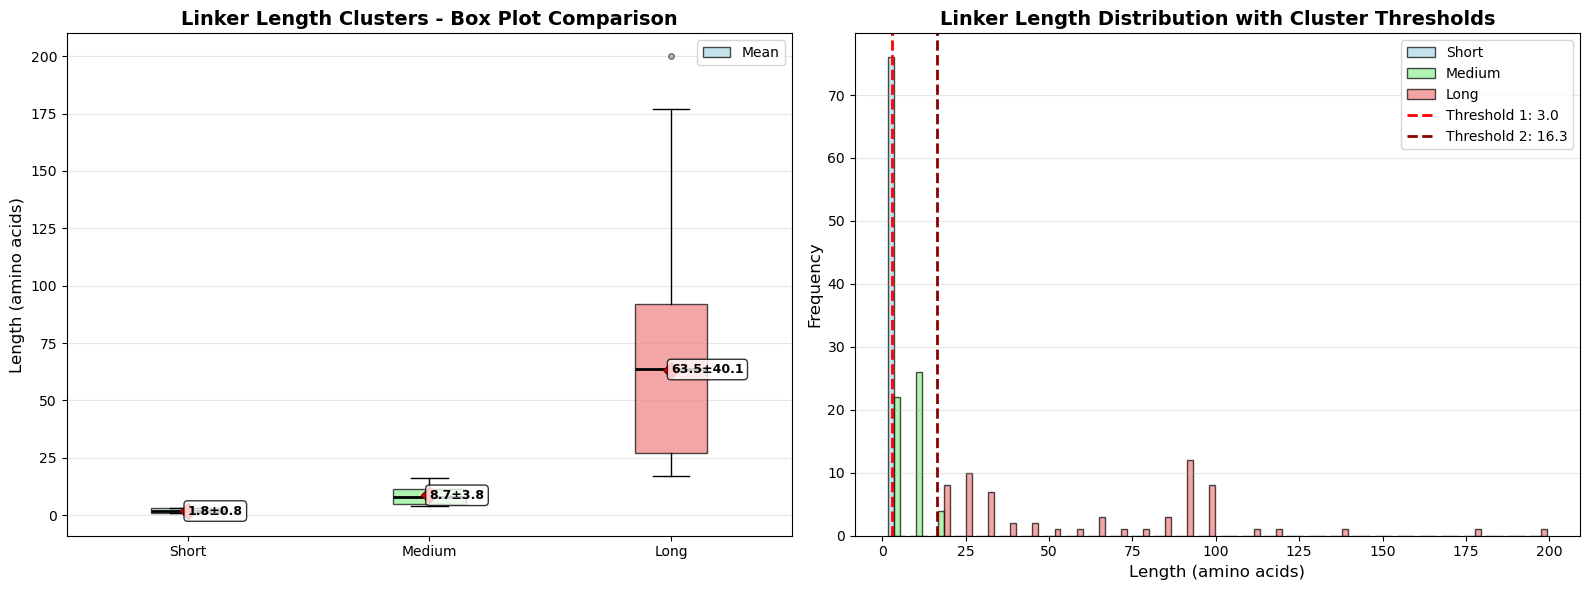

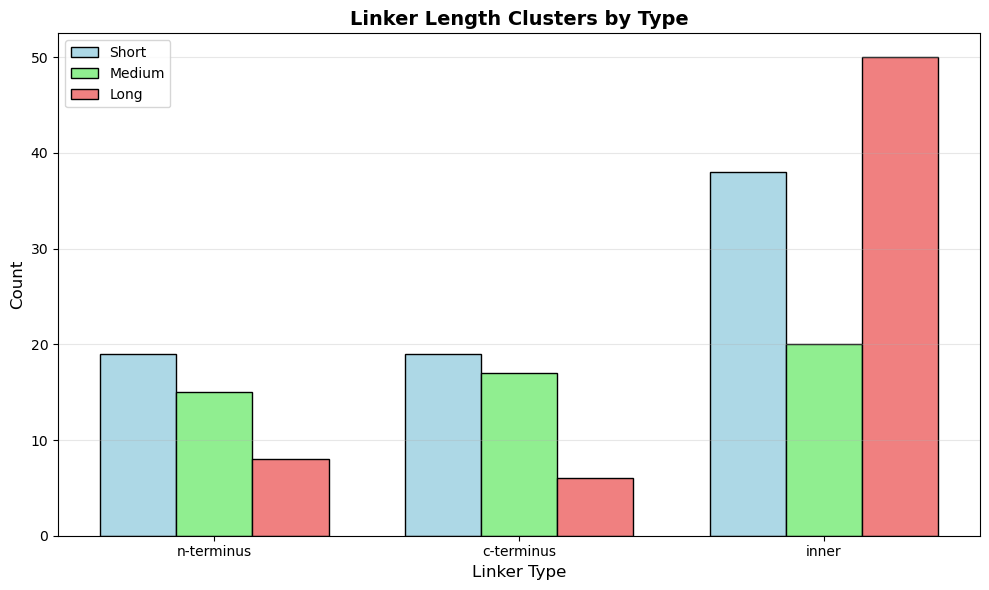


✓ Cluster analysis complete!
Cluster visualizations saved to: /home/pospim/Desktop/work/protein_linkers/input_2
CLUSTER DATA ACCESS EXAMPLES

Short linkers: 76 linkers
First 5 short linkers:
  1. P04637: n-terminus linker, positions 1-2, length 2 aa
  2. P01112: c-terminus linker, positions 189-189, length 1 aa
  3. P00734: c-terminus linker, positions 621-622, length 2 aa
  4. P0A8V2: c-terminus linker, positions 1342-1342, length 1 aa
  5. P0A7V0: n-terminus linker, positions 1-2, length 2 aa

Medium linkers: 52 linkers
First 5 medium linkers:
  1. P00533: n-terminus linker, positions 1-5, length 5 aa
  2. P00533: c-terminus linker, positions 1205-1210, length 6 aa
  3. P28482: c-terminus linker, positions 354-360, length 7 aa
  4. Q9H3U1: c-terminus linker, positions 936-944, length 9 aa
  5. Q96PU5: n-terminus linker, positions 1-14, length 14 aa

Long linkers: 64 linkers
First 5 long linkers:
  1. P04637: c-terminus linker, positions 370-393, length 24 aa
  2. P28482: n-terminus 

In [13]:
# ================================
# Cluster linkers based on length
# ================================

cluster_results = cluster_linkers_by_length(
    filtered_proteins,
    method='percentile',
    save_dir=workdir
)

# Visualize clusters
visualize_linker_clusters(cluster_results, save_dir=workdir)

print("\n✓ Cluster analysis complete!")
print(f"Cluster visualizations saved to: {os.path.expanduser(workdir)}")

# Get clusters
short_linkers = cluster_results['clusters']['short']
medium_linkers = cluster_results['clusters']['medium']
long_linkers = cluster_results['clusters']['long']

print("="*60)
print("CLUSTER DATA ACCESS EXAMPLES")
print("="*60)

print(f"\nShort linkers: {len(short_linkers)} linkers")
print("First 5 short linkers:")
for i, (acc, ltype, start, end, length) in enumerate(short_linkers[:5], 1):
    print(f"  {i}. {acc}: {ltype} linker, positions {start}-{end}, length {length} aa")

print(f"\nMedium linkers: {len(medium_linkers)} linkers")
print("First 5 medium linkers:")
for i, (acc, ltype, start, end, length) in enumerate(medium_linkers[:5], 1):
    print(f"  {i}. {acc}: {ltype} linker, positions {start}-{end}, length {length} aa")

print(f"\nLong linkers: {len(long_linkers)} linkers")
print("First 5 long linkers:")
for i, (acc, ltype, start, end, length) in enumerate(long_linkers[:5], 1):
    print(f"  {i}. {acc}: {ltype} linker, positions {start}-{end}, length {length} aa")

# Thresholds used
thresholds = cluster_results['thresholds']
print(f"\n{'='*60}")
print("THRESHOLDS USED")
print(f"{'='*60}")
print(f"Short linkers: ≤ {thresholds['short_max']:.2f} aa")
print(f"Medium linkers: {thresholds['short_max']:.2f} - {thresholds['medium_max']:.2f} aa")
print(f"Long linkers: > {thresholds['medium_max']:.2f} aa")